Occupancy Detection based on ECO dataset: Summer
=======================================

In [1]:
import sys
import numpy as np
#sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional
from keras import regularizers
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random
import scipy.io as sio

Using TensorFlow backend.


The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [2]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [3]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


The following function plots the losses against the epochs.

In [4]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

The following function calculates the sad: 

In [5]:
def calc_sad(X):
    sad = 0
#     print(X)
#     print('end of X')
    for i in X.index.tolist():
#         print(i)
        if i < X.last_valid_index():
            sad += abs(X[i] - X[i+1])
    return sad

The following function detects the on-off status:

In [6]:
def detect_onoff(X):
    on_off = 0
    thA = 30
    thT = 30
    timecount = 0
    for i in X.index.tolist():
        if i < X.last_valid_index():
#             print(timecount)
            if abs(X[i] - X[i+1]) >= thA:
                timecount += 1
            else:
                timecount = 0
            if timecount == thT:
                on_off += 1
                timecount = 0
    return on_off

In [7]:
from sklearn.metrics import confusion_matrix
def conf_matrix(X_test,y_test,model):
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    im = ax.matshow(cm)
    fig.colorbar(im)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()


In [8]:
from os import walk
path = "C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/IE594964/REP594965/01_sm_csv/01"
f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)
    break

In [9]:
df={}
for filename in f:
    datestamp = filename[:-4].replace("-","")
    #print(datestamp)
    #if int(datestamp) >= 20120715 and int(datestamp) <= 20120825:
    df[datestamp]=pd.read_csv(path+"/"+filename,header=None,names=["powerallphases","powerl1","powerl2","powerl3","currentneutral","currentl1","currentl2",
                                    "currentl3","voltagel1","voltagel2","voltagel3","phaseanglevoltagel2l1",
                                    "phaseanglevoltagel3l1","phaseanglecurrentvoltagel1","phaseanglecurrentvoltagel2",
                                    "phaseanglecurrentvoltagel3"])
len(df)

245

In [10]:
df2 = pd.read_csv("C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/IE594964/REP594965/01_occupancy_csv/01_summer.csv",index_col=0)
df2.index = pd.to_datetime(df2.index)
df2.index = df2.index.strftime('%Y%m%d')
len(df2)

39

In [11]:
import datetime
summer = df2.index.tolist()
df_summer = {}
for key in df.keys():
    if key in summer:
        df_summer[key]=df[key]
len(df_summer)
#df_summer["20120730"]

39

In [12]:
n = 900  #chunk row size
summer_features = pd.DataFrame()
for day, data in df_summer.items():
    list_df_summer = [data[i:i+n] for i in range(0,len(data),n)]
    mean123 = []
    mean1 = []
    mean2 = []
    mean3 = []
    std123 = []
    std1 = []
    std2 = []
    std3 = []
    sad1 = []
    sad2 = []
    sad3 = []
    sad123 = []
    range1 = []
    range2 = []
    range3 = []
    range123 = []
    max123 = []
    max1 = []
    max2 = []
    max3 = []
    min123 = []
    min1 = []
    min2 = []
    min3 = []
    corr123 = []
    corr1 = []
    corr2 = []
    corr3 = []
    onoff123 = []
    onoff1 = []
    onoff2 = []
    onoff3 = []
    
    for chunk in list_df_summer:
        mean123.append(np.mean(chunk['powerallphases']))
        mean1.append(np.mean(chunk['powerl1']))
        mean2.append(np.mean(chunk['powerl2']))
        mean3.append(np.mean(chunk['powerl3']))
        std123.append(np.std(chunk['powerallphases']))
        std1.append(np.std(chunk['powerl1']))
        std2.append(np.std(chunk['powerl2']))
        std3.append(np.std(chunk['powerl3']))
        range123.append(np.amax(chunk['powerallphases'] - np.amin(chunk['powerallphases'])))
        range1.append(np.amax(chunk['powerl1'] - np.amin(chunk['powerl1'])))
        range2.append(np.amax(chunk['powerl2'] - np.amin(chunk['powerl2'])))
        range3.append(np.amax(chunk['powerl3'] - np.amin(chunk['powerl3'])))
        sad123.append(calc_sad(chunk['powerallphases']))
        sad1.append(calc_sad(chunk['powerl1']))
        sad2.append(calc_sad(chunk['powerl2']))
        sad3.append(calc_sad(chunk['powerl3']))
        max123.append(np.amax(chunk['powerallphases']))
        max1.append(np.amax(chunk['powerl1']))
        max2.append(np.amax(chunk['powerl2']))
        max3.append(np.amax(chunk['powerl3']))
        min123.append(np.amin(chunk['powerallphases']))
        min1.append(np.amin(chunk['powerl1']))
        min2.append(np.amin(chunk['powerl2']))
        min3.append(np.amin(chunk['powerl3']))
        corr123.append(chunk['powerallphases'].autocorr(lag=1))
        corr1.append(chunk['powerl1'].autocorr(lag=1))
        corr2.append(chunk['powerl2'].autocorr(lag=1))
        corr3.append(chunk['powerl3'].autocorr(lag=1))
        onoff123.append(detect_onoff(chunk['powerallphases']))
        onoff1.append(detect_onoff(chunk['powerl1']))
        onoff2.append(detect_onoff(chunk['powerl2']))
        onoff3.append(detect_onoff(chunk['powerl3']))
    ptime = list(range(1,97))
    data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
                                            std1,std2,std3,std123,sad1,sad2,sad3,sad123,
                                         corr1,corr2,corr3,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,
                                         range3,range123,ptime)), 
                            columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])
    
    
    summer_features = summer_features.append(data)
summer_features.loc[summer_features.ptime < 25, 'ptime'] = 0
summer_features.loc[summer_features.ptime > 89, 'ptime'] = 0
summer_features = summer_features.loc[(summer_features['ptime'] >0)]
summer_features['ptime'] = summer_features['ptime'] - 24

summer_features

,min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,...,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,range3,range123,ptime
24,24.541,67.500,9.315,132.982,103.091,129.301,71.862,244.994,57.775494,76.168270,...,0.974188,0.0,0.0,0.0,0.0,78.550,61.801,62.547,112.012,1.0
25,24.394,64.997,9.377,115.815,116.655,1411.660,72.407,1476.630,56.177676,244.087143,...,0.992230,0.0,0.0,0.0,0.0,92.261,1346.663,63.030,1360.815,2.0
26,24.440,34.284,9.181,68.577,25.195,1362.910,10.214,1397.610,24.790351,253.476867,...,0.980321,0.0,0.0,0.0,0.0,0.755,1328.626,1.033,1329.033,3.0
27,24.500,33.878,9.176,68.723,78.227,1324.660,10.851,1390.120,57.066767,93.425890,...,0.978886,0.0,0.0,0.0,0.0,53.727,1290.782,1.675,1321.397,4.0
28,24.379,33.719,9.243,67.799,62.065,34.772,10.128,106.200,45.192284,34.198749,...,0.998727,0.0,0.0,0.0,0.0,37.686,1.053,0.885,38.401,5.0
29,24.513,33.709,9.286,67.957,98.191,95.408,10.152,162.016,27.716543,35.430220,...,0.982954,0.0,0.0,0.0,0.0,73.678,61.699,0.866,94.059,6.0
30,55.175,33.588,9.219,98.626,57.584,119.937,10.305,187.091,56.220909,40.932154,...,0.992854,0.0,0.0,0.0,0.0,2.409,86.349,1.086,88.465,7.0
31,24.532,33.656,9.229,98.555,55.756,84.390,10.243,149.174,43.084998,74.511177,...,0.995619,0.0,0.0,0.0,0.0,31.224,50.734,1.014,50.619,8.0
32,24.728,76.543,8.918,111.544,91.713,803.033,10.219,838.116,29.132812,132.700551,...,0.755625,0.0,0.0,0.0,0.0,66.985,726.490,1.301,726.572,9.0
33,55.294,125.730,8.836,191.223,57.831,136.099,71.398,255.654,56.274994,129.458838,...,0.997407,0.0,0.0,0.0,0.0,2.537,10.369,62.562,64.431,10.0


In [13]:
n = 900

cuml_list = []
for index,row in df2.iterrows():
    occ_summer = []
    list_oc_summer = [row[i:i+n] for i in range(0,len(row),n)]
    for chunk in list_oc_summer:
        occ_summer.append(np.bincount(chunk).argmax())
    occ_summer = occ_summer[24:89]
#     print(len(occ_summer))
    cuml_list.extend(occ_summer)
#     print(len(cuml_list))
occ_summer_data = pd.DataFrame(cuml_list, columns = ['occupancy'])
print(occ_summer_data)  
    

      occupancy
0             1
1             1
2             1
3             1
4             1
5             1
6             1
7             1
8             1
9             1
10            1
11            1
12            1
13            1
14            1
15            1
16            1
17            1
18            1
19            1
20            1
21            1
22            1
23            1
24            1
25            0
26            0
27            0
28            0
29            0
...         ...
2505          1
2506          1
2507          1
2508          1
2509          1
2510          1
2511          1
2512          1
2513          1
2514          1
2515          1
2516          1
2517          1
2518          1
2519          1
2520          1
2521          1
2522          1
2523          1
2524          1
2525          1
2526          1
2527          1
2528          1
2529          1
2530          1
2531          1
2532          1
2533          1
2534          1

[2535 r

Replacing all the 'nan' values by '0'

In [14]:
summer_features[np.isnan(summer_features)] = 0

Model with Manual Validation:
-----------

In [15]:
def init_model(features):
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(features,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

Data Pre-processing:


In [16]:
X = np.array(summer_features)
print('X dim: ',X.shape)
y = np.array(occ_summer_data)
print('y dim: ',y.shape)

X = normalize_data(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('X_train dim: ', X_train.shape)
print('X_tesy dim: ', X_test.shape)
print('y_train dim: ', y_train.shape)
print('y_tesy dim: ', y_test.shape)

X dim:  (2535, 33)
y dim:  (2535, 1)
X_train dim:  (2154, 33, 1)
X_tesy dim:  (381, 33, 1)
y_train dim:  (2154, 1)
y_tesy dim:  (381, 1)


In [17]:
features = X_train.shape[1]
model = init_model(features)
model.summary()

W0903 02:09:16.700221  6516 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 02:09:16.766224  6516 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 02:09:16.768224  6516 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 02:09:16.833228  6516 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0903 02:09:16.849229  6516 deprec

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 33, 256)           1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 256)           1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 33, 128)           131200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 33, 128)           512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 33, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 33, 64)            32832     
__________

Training and Testing:


Train on 2154 samples, validate on 381 samples
Epoch 1/150
 - 4s - loss: 0.6434 - acc: 0.6783 - val_loss: 0.6090 - val_acc: 0.7638
Epoch 2/150
 - 2s - loss: 0.5381 - acc: 0.7604 - val_loss: 0.4550 - val_acc: 0.8058
Epoch 3/150
 - 2s - loss: 0.4740 - acc: 0.7772 - val_loss: 0.4464 - val_acc: 0.7953
Epoch 4/150
 - 2s - loss: 0.4420 - acc: 0.7990 - val_loss: 0.4199 - val_acc: 0.8058
Epoch 5/150
 - 2s - loss: 0.4207 - acc: 0.8050 - val_loss: 0.3917 - val_acc: 0.8110
Epoch 6/150
 - 2s - loss: 0.4116 - acc: 0.8059 - val_loss: 0.3863 - val_acc: 0.8005
Epoch 7/150
 - 2s - loss: 0.3902 - acc: 0.8157 - val_loss: 0.4038 - val_acc: 0.8110
Epoch 8/150
 - 3s - loss: 0.3892 - acc: 0.8166 - val_loss: 0.3938 - val_acc: 0.8136
Epoch 9/150
 - 2s - loss: 0.3899 - acc: 0.8101 - val_loss: 0.3589 - val_acc: 0.8294
Epoch 10/150
 - 2s - loss: 0.3679 - acc: 0.8213 - val_loss: 0.3649 - val_acc: 0.8241
Epoch 11/150
 - 2s - loss: 0.3837 - acc: 0.8208 - val_loss: 0.3547 - val_acc: 0.8268
Epoch 12/150
 - 2s - loss: 

Epoch 97/150
 - 2s - loss: 0.2673 - acc: 0.8774 - val_loss: 0.3377 - val_acc: 0.8425
Epoch 98/150
 - 2s - loss: 0.2528 - acc: 0.8844 - val_loss: 0.3269 - val_acc: 0.8478
Epoch 99/150
 - 2s - loss: 0.2737 - acc: 0.8779 - val_loss: 0.3378 - val_acc: 0.8478
Epoch 100/150
 - 2s - loss: 0.2499 - acc: 0.8881 - val_loss: 0.3252 - val_acc: 0.8478
Epoch 101/150
 - 2s - loss: 0.2554 - acc: 0.8784 - val_loss: 0.3504 - val_acc: 0.8530
Epoch 102/150
 - 2s - loss: 0.2546 - acc: 0.8816 - val_loss: 0.3260 - val_acc: 0.8556
Epoch 103/150
 - 2s - loss: 0.2603 - acc: 0.8858 - val_loss: 0.3386 - val_acc: 0.8504
Epoch 104/150
 - 2s - loss: 0.2457 - acc: 0.8979 - val_loss: 0.3270 - val_acc: 0.8478
Epoch 105/150
 - 2s - loss: 0.2596 - acc: 0.8867 - val_loss: 0.3368 - val_acc: 0.8425
Epoch 106/150
 - 2s - loss: 0.2559 - acc: 0.8867 - val_loss: 0.3276 - val_acc: 0.8530
Epoch 107/150
 - 2s - loss: 0.2643 - acc: 0.8844 - val_loss: 0.3462 - val_acc: 0.8399
Epoch 108/150
 - 3s - loss: 0.2483 - acc: 0.8890 - val_lo

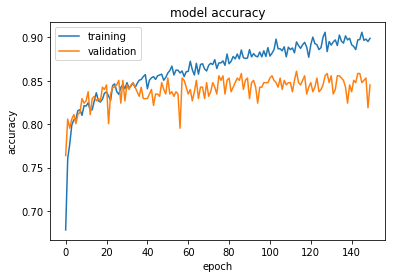

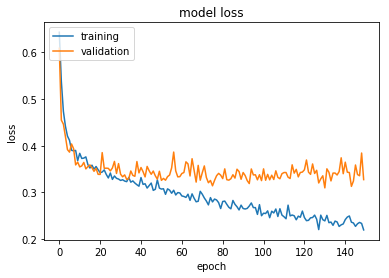

In [18]:
history = LossHistory()
hiss = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score)

plt.plot(hiss.history['acc'])
plt.plot(hiss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss.history['loss'])
plt.plot(hiss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

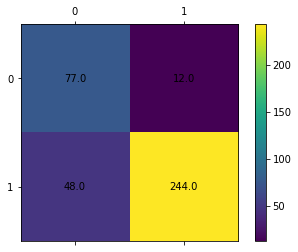

In [24]:
from sklearn.metrics import confusion_matrix
def conf_matrix(X_test,y_test,model):
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    im = ax.matshow(cm)
    fig.colorbar(im)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()

conf_matrix(X_test,y_test,model)

Classification error: 84.78

Early Stopping:
------

In [25]:
model = init_model(features)

Training and Testing:


Train on 2154 samples, validate on 381 samples
Epoch 1/150
 - 4s - loss: 0.6195 - acc: 0.6829 - val_loss: 0.5699 - val_acc: 0.7507
Epoch 2/150
 - 2s - loss: 0.5056 - acc: 0.7669 - val_loss: 0.5469 - val_acc: 0.7559
Epoch 3/150
 - 2s - loss: 0.4447 - acc: 0.7957 - val_loss: 0.4195 - val_acc: 0.8136
Epoch 4/150
 - 2s - loss: 0.4406 - acc: 0.7967 - val_loss: 0.4317 - val_acc: 0.8163
Epoch 5/150
 - 2s - loss: 0.4191 - acc: 0.8018 - val_loss: 0.4098 - val_acc: 0.8136
Epoch 6/150
 - 3s - loss: 0.3980 - acc: 0.8171 - val_loss: 0.4096 - val_acc: 0.8031
Epoch 7/150
 - 2s - loss: 0.4068 - acc: 0.8069 - val_loss: 0.3888 - val_acc: 0.8268
Epoch 8/150
 - 2s - loss: 0.3974 - acc: 0.8073 - val_loss: 0.3703 - val_acc: 0.8268
Epoch 9/150
 - 2s - loss: 0.3944 - acc: 0.8217 - val_loss: 0.3839 - val_acc: 0.8189
Epoch 10/150
 - 2s - loss: 0.3879 - acc: 0.8166 - val_loss: 0.3663 - val_acc: 0.8451
Epoch 11/150
 - 2s - loss: 0.3680 - acc: 0.8329 - val_loss: 0.3613 - val_acc: 0.8163
Epoch 12/150
 - 3s - loss: 

Epoch 97/150
 - 2s - loss: 0.2737 - acc: 0.8756 - val_loss: 0.3387 - val_acc: 0.8530
Epoch 98/150
 - 2s - loss: 0.2691 - acc: 0.8747 - val_loss: 0.3555 - val_acc: 0.8504
Epoch 99/150
 - 2s - loss: 0.2691 - acc: 0.8802 - val_loss: 0.3566 - val_acc: 0.8268
Epoch 100/150
 - 2s - loss: 0.2550 - acc: 0.8853 - val_loss: 0.3566 - val_acc: 0.8425
Epoch 101/150
 - 2s - loss: 0.2642 - acc: 0.8751 - val_loss: 0.3338 - val_acc: 0.8504
Epoch 102/150
 - 3s - loss: 0.2641 - acc: 0.8807 - val_loss: 0.3441 - val_acc: 0.8399
Epoch 103/150
 - 3s - loss: 0.2572 - acc: 0.8812 - val_loss: 0.3727 - val_acc: 0.8346
Epoch 104/150
 - 3s - loss: 0.2558 - acc: 0.8895 - val_loss: 0.3469 - val_acc: 0.8399
Epoch 105/150
 - 3s - loss: 0.2627 - acc: 0.8774 - val_loss: 0.3393 - val_acc: 0.8346
Epoch 106/150
 - 2s - loss: 0.2661 - acc: 0.8877 - val_loss: 0.3504 - val_acc: 0.8451
Epoch 107/150
 - 3s - loss: 0.2582 - acc: 0.8784 - val_loss: 0.3696 - val_acc: 0.8425
Epoch 108/150
 - 2s - loss: 0.2510 - acc: 0.8839 - val_lo

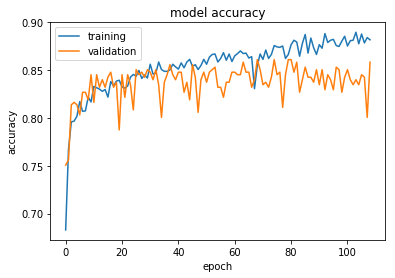

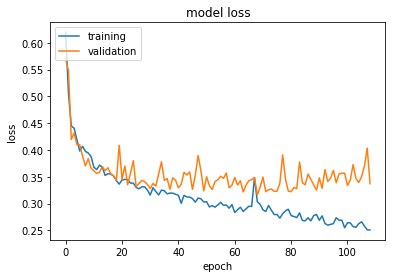

In [26]:
history = LossHistory()
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[history,es],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score)

plt.plot(hiss.history['acc'])
plt.plot(hiss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss.history['loss'])
plt.plot(hiss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

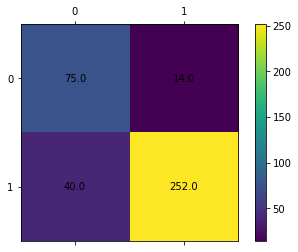

In [27]:
conf_matrix(X_test,y_test,model)

Model with K-fold Validation:
----------

acc: 83.20%


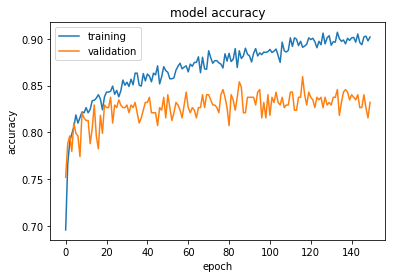

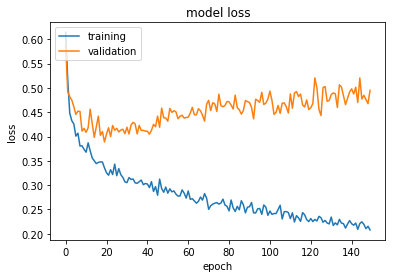

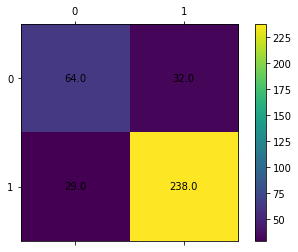

acc: 82.87%


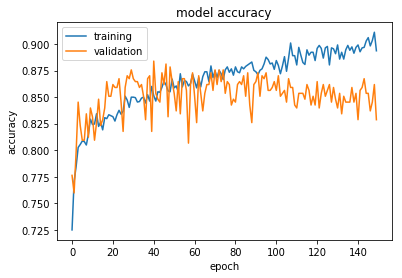

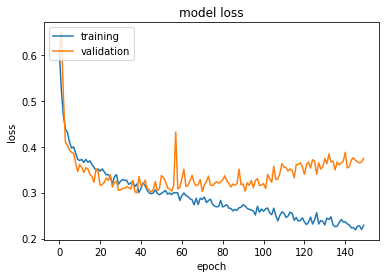

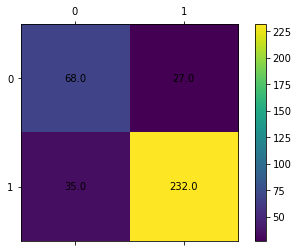

acc: 83.15%


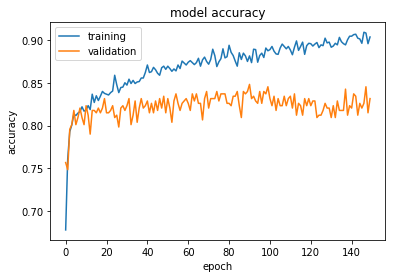

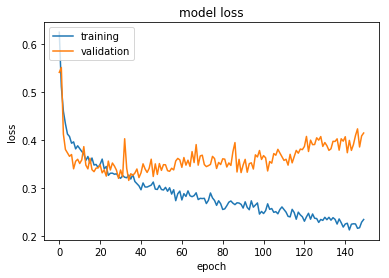

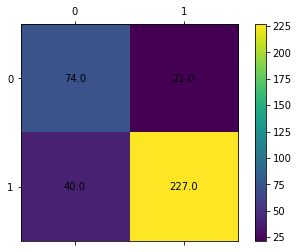

acc: 88.12%


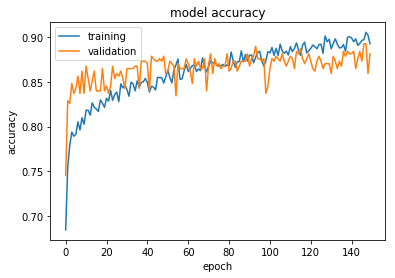

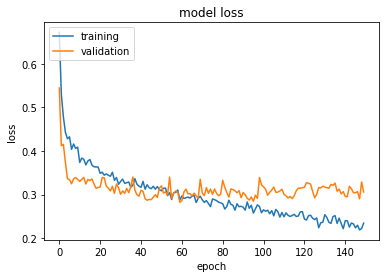

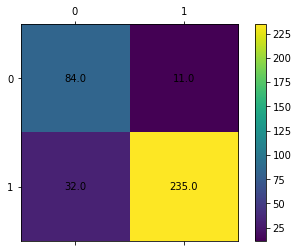

acc: 84.81%


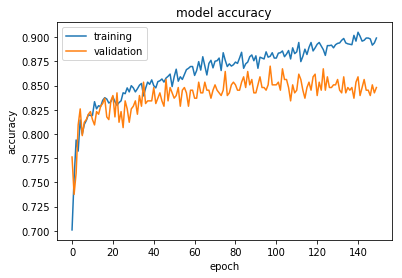

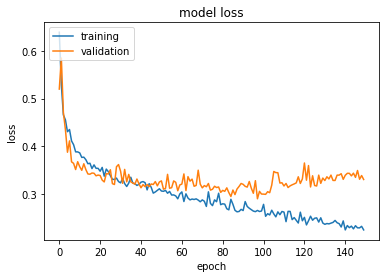

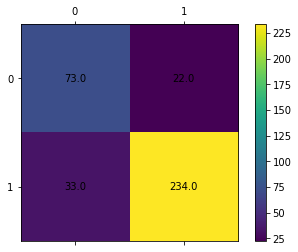

acc: 84.81%


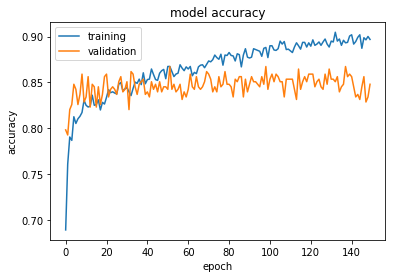

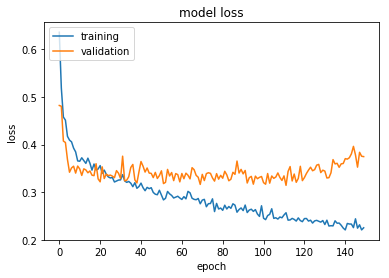

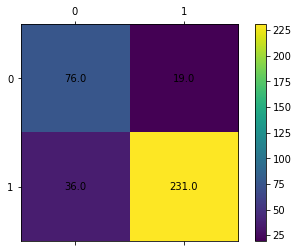

acc: 87.29%


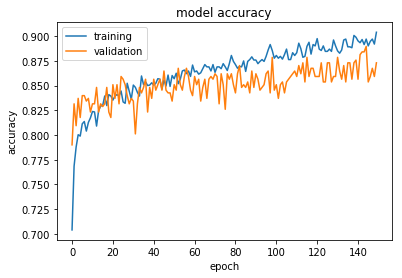

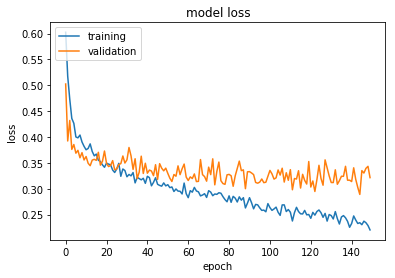

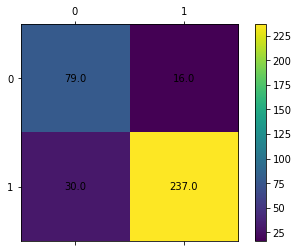

In [28]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
loss = []
for train, test in kfold.split(X, y):
    
    model = init_model(features)
    
    X_train_k =X[train].reshape(X[train].shape[0], X[train].shape[1], 1)
    X_test_k = X[test].reshape(X[test].shape[0], X[test].shape[1], 1)
    history = LossHistory()
    hiss = model.fit(X_train_k, y[train], epochs=150, batch_size=32,
                callbacks=[history],
                validation_data=(X_test_k,y[test]), verbose=0)
    scores = model.evaluate(X_test_k, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    loss.append(scores[0])
#     print(score)
    plt.plot(hiss.history['acc'])
    plt.plot(hiss.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss.history['loss'])
    plt.plot(hiss.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_k,y[test],model)


In [29]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss), np.std(loss)))

accuracy::  84.89% (+/- 1.93%)
error:: 0.37 (+/- 0.06)


Shapely Values:
-------

In [36]:
import shap

# select a set of background examples to take an expectation over
background = X_train
X_train.shape

(2154, 33, 1)

In [37]:
model = init_model(features)
# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
shap_values = e.shap_values(X_train)

In [38]:
shap_values[0]= shap_values[0].reshape(shap_values[0].shape[0],shap_values[0].shape[1])
shap_values[0].shape

X_postprocess = X_train.reshape(X_train.shape[0],X_train.shape[1])
X_postprocess.shape

(2154, 33)

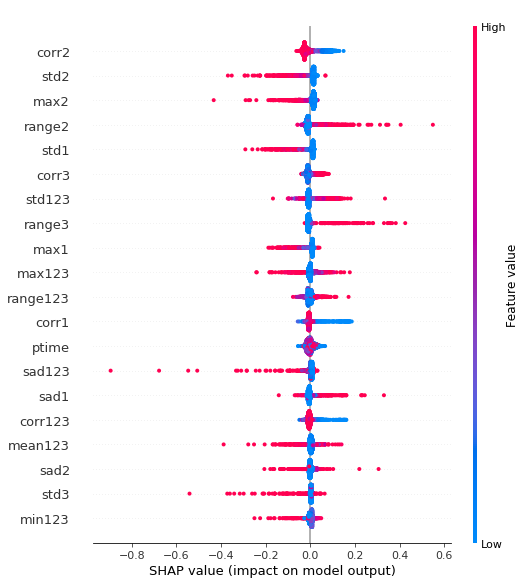

In [39]:
shap.summary_plot(shap_values[0], X_postprocess, feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

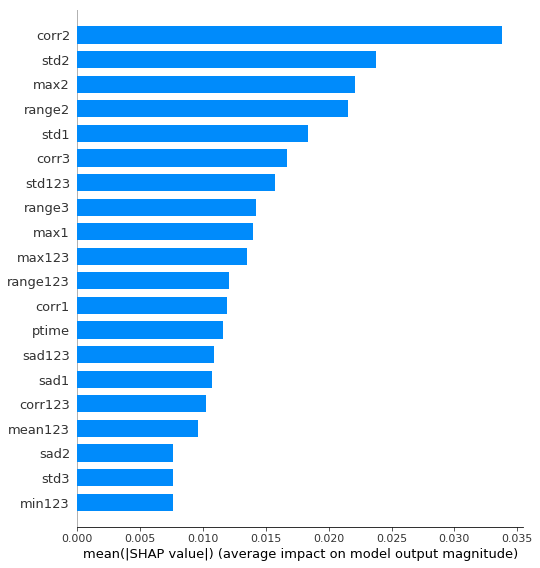

In [40]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar", feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

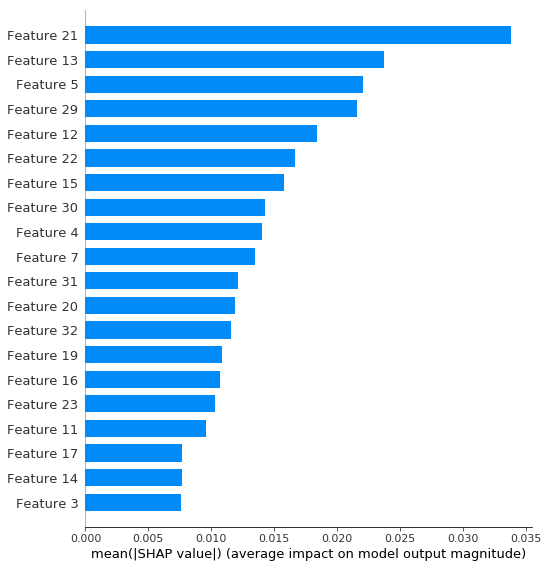

In [41]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar")

After Feature Reduction by Shapely Values
-------------

In [45]:
new_summer_features = np.concatenate((X[:,3:6],X[:,7][:, np.newaxis],X[:,11:18], X[:,19:24],X[:,29:33]),axis=1)
new_summer_features.shape

(2535, 20)

In [46]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(new_summer_features, y, test_size=0.15, shuffle=True)

X_train_s = X_train_s.reshape(X_train_s.shape[0], X_train_s.shape[1], 1)
X_test_s = X_test_s.reshape(X_test_s.shape[0], X_test_s.shape[1], 1)

print('X_train dim: ', X_train_s.shape)
print('X_tesy dim: ', X_test_s.shape)
print('y_train dim: ', y_train_s.shape)
print('y_tesy dim: ', y_test_s.shape)

X_train dim:  (2154, 20, 1)
X_tesy dim:  (381, 20, 1)
y_train dim:  (2154, 1)
y_tesy dim:  (381, 1)


In [47]:
features_s = 20
model = init_model(features_s)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 20, 256)           1280      
_________________________________________________________________
batch_normalization_73 (Batc (None, 20, 256)           1024      
_________________________________________________________________
dropout_73 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 20, 128)           131200    
_________________________________________________________________
batch_normalization_74 (Batc (None, 20, 128)           512       
_________________________________________________________________
dropout_74 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 20, 64)            32832     
__________

In [ ]:
history_s = LossHistory()
hiss_s = model.fit(X_train_s, y_train_s, epochs=150, batch_size=32,
                callbacks=[history_s],
                validation_data=(X_test_s,y_test_s), verbose=2)
score_s = model.evaluate(X_test_s,y_test_s, batch_size=32)
print(score_s)
plt.plot(hiss_s.history['acc'])
plt.plot(hiss_s.history['val_acc'])
plt.title('model accuracy_post shap')
plt.ylabel('accuracy_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_s.history['loss'])
plt.plot(hiss_s.history['val_loss'])
plt.title('model loss_post shap')
plt.ylabel('loss_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

y_pred = model.predict(X_test_s)

In [ ]:
conf_matrix(X_test_s,y_test_s,model)

Early Stopping:
------

In [48]:
model = init_model(features_s)

Training and Testing:


Train on 2154 samples, validate on 381 samples
Epoch 1/150
 - 6s - loss: 0.6642 - acc: 0.6537 - val_loss: 0.5933 - val_acc: 0.7559
Epoch 2/150
 - 2s - loss: 0.5136 - acc: 0.7632 - val_loss: 0.4780 - val_acc: 0.8005
Epoch 3/150
 - 2s - loss: 0.4582 - acc: 0.7948 - val_loss: 0.4382 - val_acc: 0.8136
Epoch 4/150
 - 2s - loss: 0.4365 - acc: 0.7994 - val_loss: 0.4079 - val_acc: 0.8031
Epoch 5/150
 - 2s - loss: 0.4207 - acc: 0.8087 - val_loss: 0.3938 - val_acc: 0.8084
Epoch 6/150
 - 2s - loss: 0.4223 - acc: 0.7985 - val_loss: 0.3897 - val_acc: 0.7953
Epoch 7/150
 - 2s - loss: 0.4075 - acc: 0.8087 - val_loss: 0.4066 - val_acc: 0.8163
Epoch 8/150
 - 2s - loss: 0.4069 - acc: 0.7999 - val_loss: 0.3812 - val_acc: 0.8084
Epoch 9/150
 - 2s - loss: 0.3996 - acc: 0.8217 - val_loss: 0.3716 - val_acc: 0.8241
Epoch 10/150
 - 2s - loss: 0.3797 - acc: 0.8296 - val_loss: 0.3691 - val_acc: 0.8163
Epoch 11/150
 - 2s - loss: 0.3858 - acc: 0.8124 - val_loss: 0.3683 - val_acc: 0.8189
Epoch 12/150
 - 2s - loss: 

Epoch 97/150
 - 2s - loss: 0.2621 - acc: 0.8807 - val_loss: 0.3509 - val_acc: 0.8320
Epoch 98/150
 - 2s - loss: 0.2715 - acc: 0.8793 - val_loss: 0.3565 - val_acc: 0.8373
Epoch 99/150
 - 2s - loss: 0.2771 - acc: 0.8709 - val_loss: 0.3605 - val_acc: 0.8163
Epoch 100/150
 - 2s - loss: 0.2607 - acc: 0.8821 - val_loss: 0.3617 - val_acc: 0.8084
Epoch 101/150
 - 2s - loss: 0.2755 - acc: 0.8737 - val_loss: 0.3759 - val_acc: 0.8294
Epoch 102/150
 - 2s - loss: 0.2657 - acc: 0.8728 - val_loss: 0.3813 - val_acc: 0.8215
Epoch 103/150
 - 2s - loss: 0.2682 - acc: 0.8770 - val_loss: 0.3788 - val_acc: 0.8005
Epoch 104/150
 - 2s - loss: 0.2767 - acc: 0.8714 - val_loss: 0.3625 - val_acc: 0.8215
Epoch 105/150
 - 2s - loss: 0.2791 - acc: 0.8737 - val_loss: 0.3759 - val_acc: 0.8084
Epoch 106/150
 - 2s - loss: 0.2737 - acc: 0.8784 - val_loss: 0.3584 - val_acc: 0.8189
Epoch 107/150
 - 2s - loss: 0.2715 - acc: 0.8760 - val_loss: 0.3530 - val_acc: 0.8320
Epoch 108/150
 - 2s - loss: 0.2652 - acc: 0.8784 - val_lo

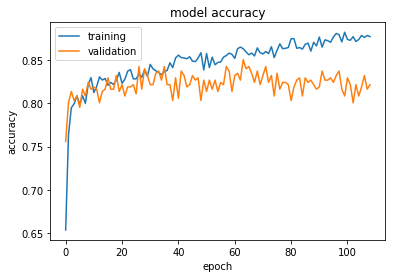

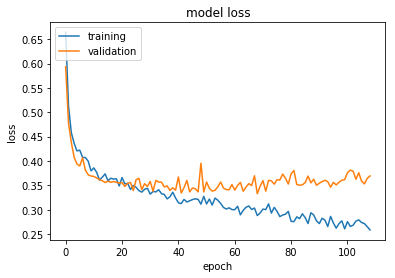

In [49]:
history_se = LossHistory()
es_se = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss_se = model.fit(X_train_s, y_train_s, epochs=150, batch_size=32,
                callbacks=[history,es_se],
                validation_data=(X_test_s,y_test_s), verbose=2)
score_se = model.evaluate(X_test_s, y_test_s, batch_size=32)
print('loss and accuracy:: ',score_se)

plt.plot(hiss_se.history['acc'])
plt.plot(hiss_se.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_se.history['loss'])
plt.plot(hiss_se.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

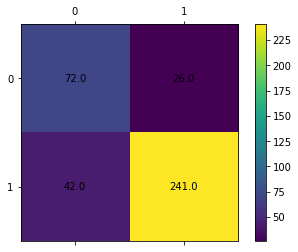

In [50]:
conf_matrix(X_test_s,y_test_s,model)

Model with K-fold Validation:
----------

Epoch 00060: early stopping
acc: 81.54%


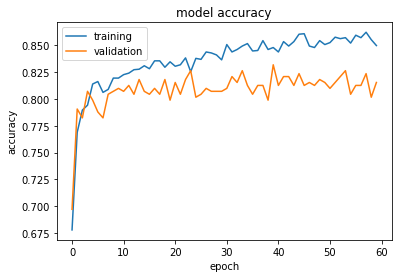

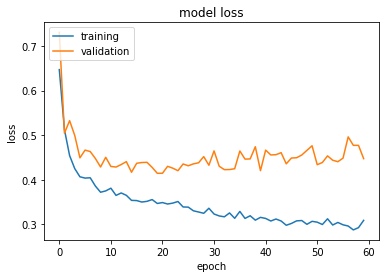

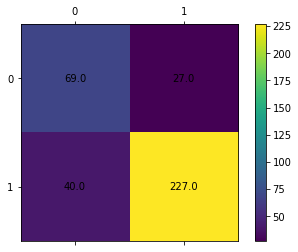

Epoch 00089: early stopping
acc: 85.64%


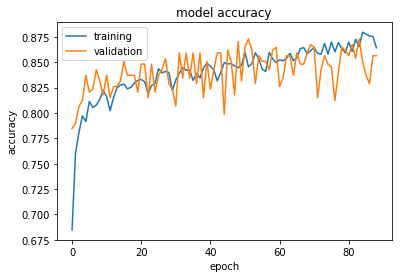

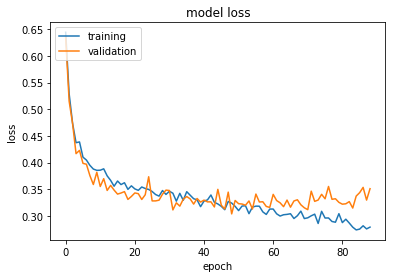

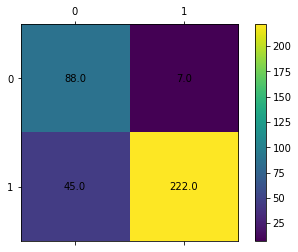

Epoch 00102: early stopping
acc: 84.81%


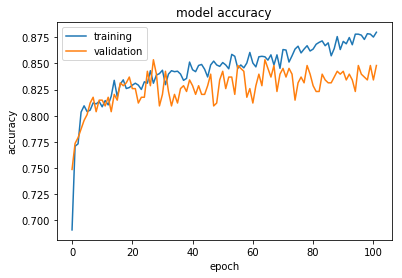

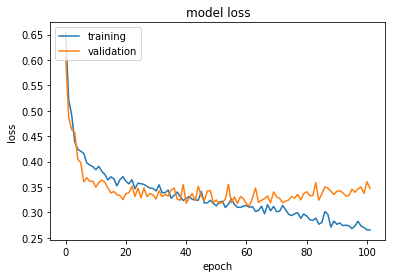

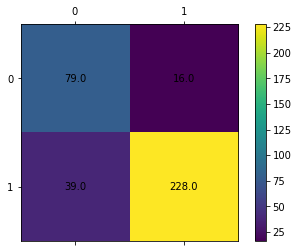

acc: 86.19%


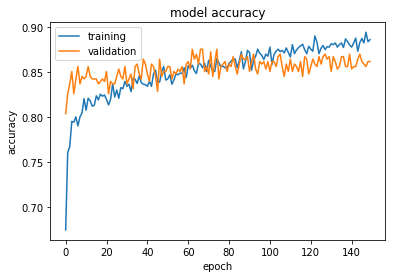

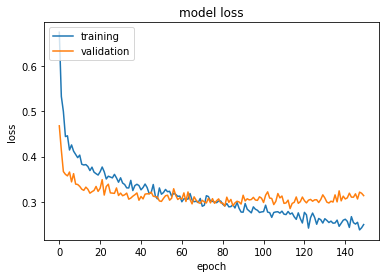

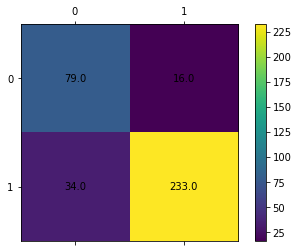

Epoch 00089: early stopping
acc: 84.25%


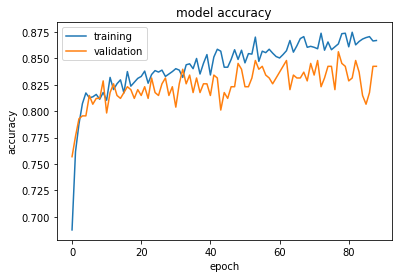

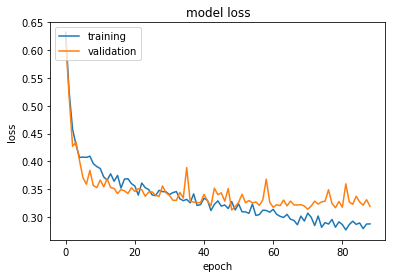

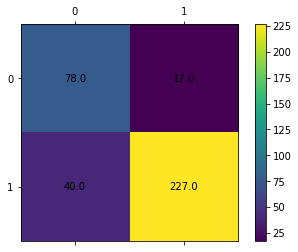

Epoch 00120: early stopping
acc: 86.19%


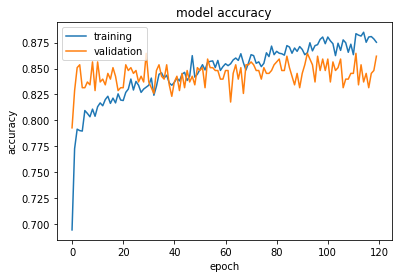

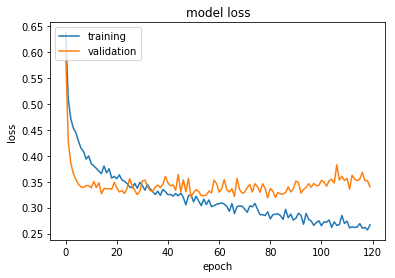

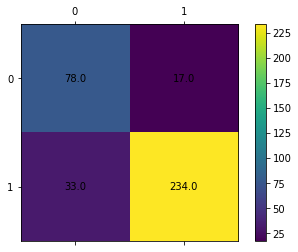

Epoch 00118: early stopping
acc: 87.02%


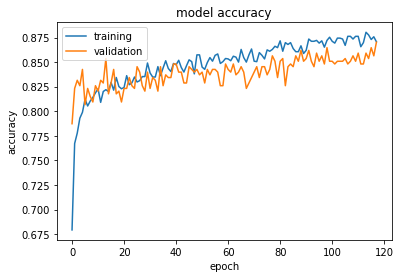

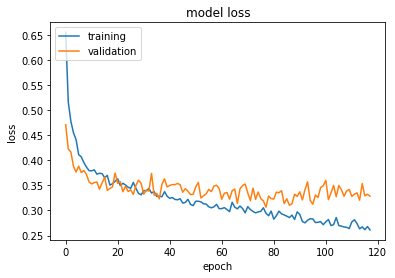

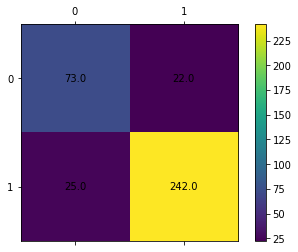

In [51]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold_s = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores_s = []
loss_s = []
XX = new_summer_features
for train, test in kfold_s.split(XX, y):
    
    model = init_model(features_s)
    
    X_train_ks =XX[train].reshape(XX[train].shape[0], XX[train].shape[1], 1)
    X_test_ks = XX[test].reshape(XX[test].shape[0], XX[test].shape[1], 1)
    history_ks = LossHistory()
    es_ks = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    hiss_ks = model.fit(X_train_ks, y[train], epochs=150, batch_size=32,
                callbacks=[history_ks,es_ks],
                validation_data=(X_test_ks,y[test]), verbose=0)
    scores_ks = model.evaluate(X_test_ks, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores_ks[1]*100))
    cvscores_s.append(scores_ks[1] * 100)
    loss_s.append(scores_ks[0])
#     print(score)
    plt.plot(hiss_ks.history['acc'])
    plt.plot(hiss_ks.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss_ks.history['loss'])
    plt.plot(hiss_ks.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_ks,y[test],model)


In [52]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_s), np.std(cvscores_s)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss_s), np.std(loss_s)))

accuracy::  85.09% (+/- 1.68%)
error:: 0.35 (+/- 0.04)


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 78.79%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 78.73%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 81.22%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 84.53%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 82.87%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 84.25%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.39%
81.54% (+/- 2.24%)


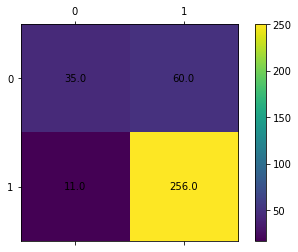

In [53]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score 
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(XX, y):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = XX[train]
    X_test = XX[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, y[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(y[test], y_pred)
    acc = accuracy_score(y[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

PCA:
-------

In [96]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.99)
X.shape

(2535, 33)

In [55]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [56]:
pca.n_components_

18

In [57]:
summer_pca = pca.transform(X)

In [58]:
summer_pca.shape

(2535, 18)

In [59]:
from sklearn.model_selection import train_test_split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(summer_pca, y, test_size=0.15, shuffle=True)

In [60]:
X_train_p.shape

(2154, 18)

Early Stopping:
------

In [61]:
features_p = X_train_p.shape[1]
model = init_model(features_p)

X_train_p = X_train_p.reshape(X_train_p.shape[0], X_train_p.shape[1], 1)
X_test_p = X_test_p.reshape(X_test_p.shape[0], X_test_p.shape[1], 1)

print('X_train dim: ', X_train_p.shape)
print('X_tesy dim: ', X_test_p.shape)
print('y_train dim: ', y_train_p.shape)
print('y_tesy dim: ', y_test_p.shape)

X_train dim:  (2154, 18, 1)
X_tesy dim:  (381, 18, 1)
y_train dim:  (2154, 1)
y_tesy dim:  (381, 1)


Training and Testing:


Train on 2154 samples, validate on 381 samples
Epoch 1/150
 - 7s - loss: 0.6787 - acc: 0.6588 - val_loss: 0.5576 - val_acc: 0.7297
Epoch 2/150
 - 2s - loss: 0.5193 - acc: 0.7544 - val_loss: 0.4698 - val_acc: 0.7612
Epoch 3/150
 - 2s - loss: 0.4887 - acc: 0.7748 - val_loss: 0.5090 - val_acc: 0.7690
Epoch 4/150
 - 2s - loss: 0.4395 - acc: 0.7934 - val_loss: 0.4646 - val_acc: 0.7585
Epoch 5/150
 - 2s - loss: 0.4417 - acc: 0.7981 - val_loss: 0.4437 - val_acc: 0.7690
Epoch 6/150
 - 2s - loss: 0.4215 - acc: 0.7943 - val_loss: 0.4284 - val_acc: 0.7795
Epoch 7/150
 - 2s - loss: 0.4131 - acc: 0.8138 - val_loss: 0.4327 - val_acc: 0.7979
Epoch 8/150
 - 2s - loss: 0.4044 - acc: 0.7990 - val_loss: 0.4247 - val_acc: 0.7953
Epoch 9/150
 - 2s - loss: 0.4046 - acc: 0.8022 - val_loss: 0.4136 - val_acc: 0.7953
Epoch 10/150
 - 2s - loss: 0.3811 - acc: 0.8120 - val_loss: 0.4153 - val_acc: 0.7927
Epoch 11/150
 - 2s - loss: 0.3893 - acc: 0.8250 - val_loss: 0.4097 - val_acc: 0.8058
Epoch 12/150
 - 2s - loss: 

Epoch 97/150
 - 2s - loss: 0.2676 - acc: 0.8821 - val_loss: 0.3805 - val_acc: 0.8425
Epoch 98/150
 - 2s - loss: 0.2744 - acc: 0.8700 - val_loss: 0.3732 - val_acc: 0.8163
Epoch 99/150
 - 2s - loss: 0.2720 - acc: 0.8756 - val_loss: 0.3730 - val_acc: 0.8320
Epoch 100/150
 - 2s - loss: 0.2669 - acc: 0.8751 - val_loss: 0.3622 - val_acc: 0.8215
Epoch 101/150
 - 2s - loss: 0.2665 - acc: 0.8821 - val_loss: 0.3792 - val_acc: 0.8163
Epoch 102/150
 - 2s - loss: 0.2643 - acc: 0.8779 - val_loss: 0.3682 - val_acc: 0.8373
Epoch 103/150
 - 2s - loss: 0.2679 - acc: 0.8770 - val_loss: 0.4030 - val_acc: 0.8058
Epoch 104/150
 - 2s - loss: 0.2623 - acc: 0.8821 - val_loss: 0.3745 - val_acc: 0.8478
Epoch 105/150
 - 2s - loss: 0.2750 - acc: 0.8719 - val_loss: 0.3783 - val_acc: 0.8268
Epoch 106/150
 - 2s - loss: 0.2642 - acc: 0.8788 - val_loss: 0.3862 - val_acc: 0.8346
Epoch 107/150
 - 2s - loss: 0.2537 - acc: 0.8853 - val_loss: 0.3791 - val_acc: 0.8346
Epoch 108/150
 - 2s - loss: 0.2673 - acc: 0.8700 - val_lo

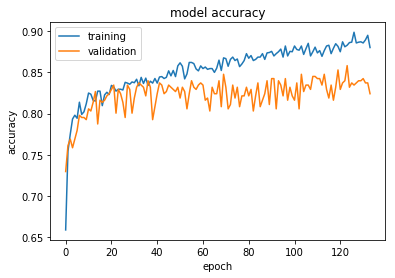

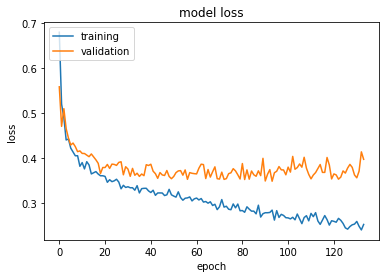

In [62]:
history_pe = LossHistory()
es_pe = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss_pe = model.fit(X_train_p, y_train_p, epochs=150, batch_size=32,
                callbacks=[history_pe,es_pe],
                validation_data=(X_test_p,y_test_p), verbose=2)
score_pe = model.evaluate(X_test_p, y_test_p, batch_size=32)
print('loss and accuracy:: ',score_pe)

plt.plot(hiss_pe.history['acc'])
plt.plot(hiss_pe.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_pe.history['loss'])
plt.plot(hiss_pe.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

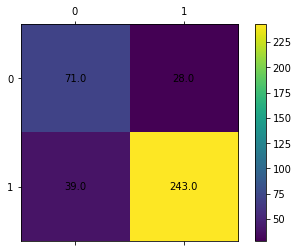

In [63]:
conf_matrix(X_test_p,y_test_p,model)

Model with K-fold Validation:
----------

Epoch 00060: early stopping
acc: 82.64%


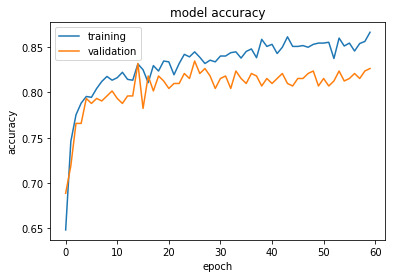

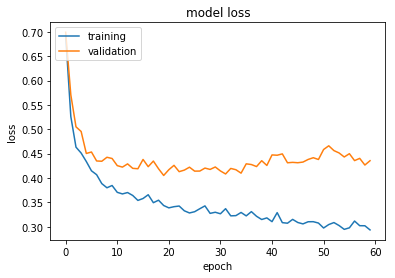

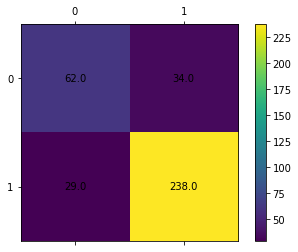

Epoch 00095: early stopping
acc: 82.87%


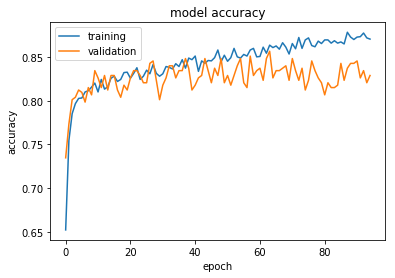

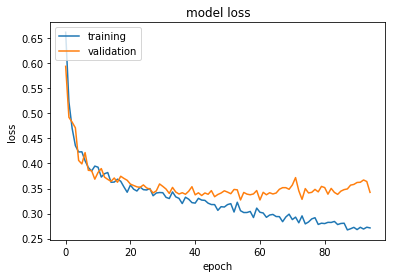

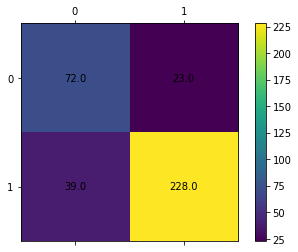

Epoch 00077: early stopping
acc: 83.43%


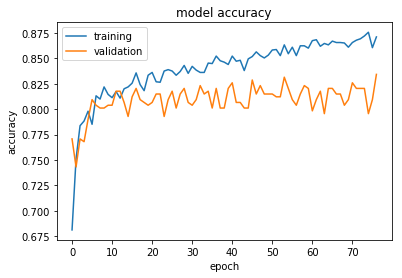

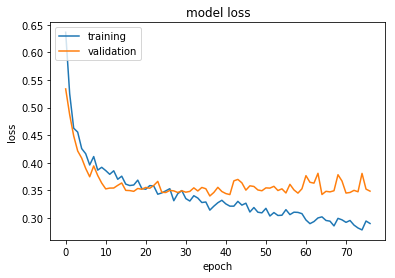

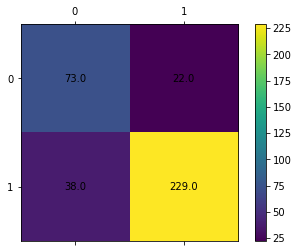

Epoch 00097: early stopping
acc: 85.64%


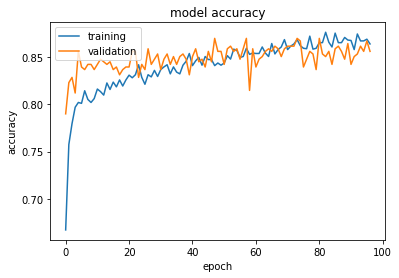

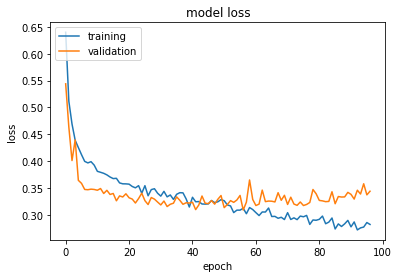

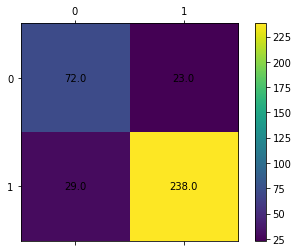

Epoch 00090: early stopping
acc: 83.98%


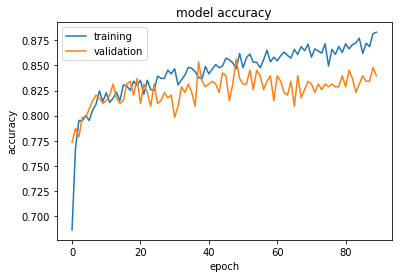

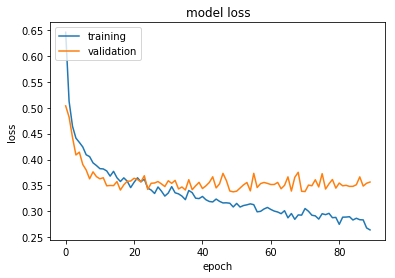

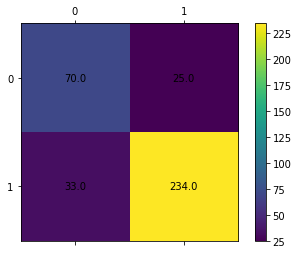

Epoch 00127: early stopping
acc: 83.43%


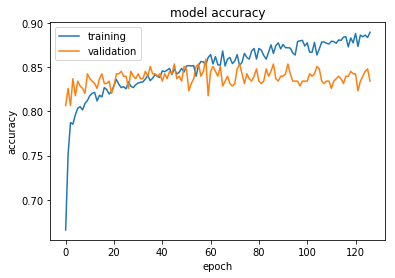

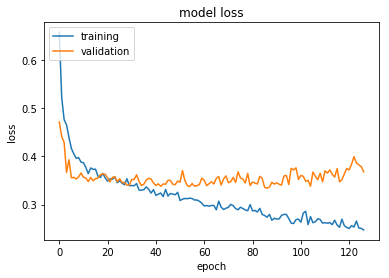

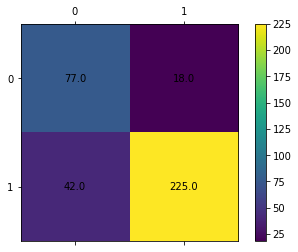

Epoch 00146: early stopping
acc: 82.32%


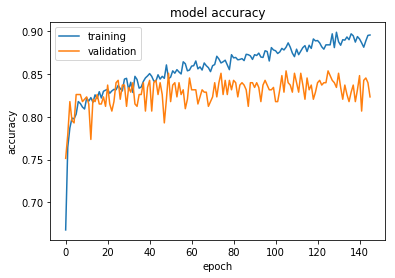

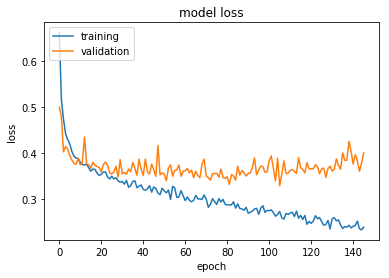

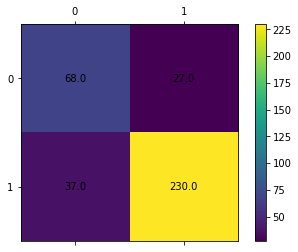

In [64]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold_p = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores_p = []
loss_p = []
XXX = summer_pca
for train, test in kfold_s.split(XXX, y):
    
    model = init_model(features_p)
    
    X_train_kp =XXX[train].reshape(XXX[train].shape[0], XXX[train].shape[1], 1)
    X_test_kp = XXX[test].reshape(XXX[test].shape[0], XXX[test].shape[1], 1)
    history_kp = LossHistory()
    es_kp = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    hiss_kp = model.fit(X_train_kp, y[train], epochs=150, batch_size=32,
                callbacks=[history_kp,es_kp],
                validation_data=(X_test_kp,y[test]), verbose=0)
    scores_kp = model.evaluate(X_test_kp, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores_kp[1]*100))
    cvscores_p.append(scores_kp[1] * 100)
    loss_p.append(scores_kp[0])
#     print(score)
    plt.plot(hiss_kp.history['acc'])
    plt.plot(hiss_kp.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss_kp.history['loss'])
    plt.plot(hiss_kp.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_kp,y[test],model)


In [65]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_p), np.std(cvscores_p)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss_p), np.std(loss_p)))

accuracy::  83.47% (+/- 1.02%)
error:: 0.37 (+/- 0.03)


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 78.79%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 79.01%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.94%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 84.81%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 82.04%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 84.25%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.66%
81.50% (+/- 2.18%)


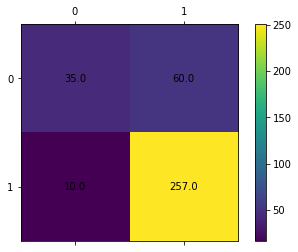

In [66]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score 
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(XXX, y):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = XXX[train]
    X_test = XXX[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, y[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(y[test], y_pred)
    acc = accuracy_score(y[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

SA+PCA:
------

In [67]:
pca_s = PCA(.99)

In [77]:
pca_s.fit(XX)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [78]:
pca_s.n_components_

14

In [80]:
XX.shape

(2535, 20)

In [82]:
summer_pca_s = pca_s.transform(XX)

In [83]:
summer_pca_s.shape

(2535, 14)

In [84]:
from sklearn.model_selection import train_test_split
X_train_ps, X_test_ps, y_train_ps, y_test_ps = train_test_split(summer_pca_s, y, test_size=0.15, shuffle=True)

In [85]:
X_train_ps.shape

(2154, 14)

Early Stopping:
------

In [87]:
features_ps = X_train_ps.shape[1]
model = init_model(features_ps)

X_train_ps = X_train_ps.reshape(X_train_ps.shape[0], X_train_ps.shape[1], 1)
X_test_ps = X_test_ps.reshape(X_test_ps.shape[0], X_test_ps.shape[1], 1)

print('X_train dim: ', X_train_ps.shape)
print('X_tesy dim: ', X_test_ps.shape)
print('y_train dim: ', y_train_ps.shape)
print('y_tesy dim: ', y_test_ps.shape)

X_train dim:  (2154, 14, 1)
X_tesy dim:  (381, 14, 1)
y_train dim:  (2154, 1)
y_tesy dim:  (381, 1)


Training and Testing:


Train on 2154 samples, validate on 381 samples
Epoch 1/150
 - 9s - loss: 0.7092 - acc: 0.6602 - val_loss: 0.5798 - val_acc: 0.7848
Epoch 2/150
 - 2s - loss: 0.5374 - acc: 0.7530 - val_loss: 0.4691 - val_acc: 0.7979
Epoch 3/150
 - 2s - loss: 0.4814 - acc: 0.7702 - val_loss: 0.4540 - val_acc: 0.7953
Epoch 4/150
 - 2s - loss: 0.4700 - acc: 0.7911 - val_loss: 0.3997 - val_acc: 0.8268
Epoch 5/150
 - 2s - loss: 0.4335 - acc: 0.8022 - val_loss: 0.4084 - val_acc: 0.8163
Epoch 6/150
 - 2s - loss: 0.4368 - acc: 0.7971 - val_loss: 0.3838 - val_acc: 0.8110
Epoch 7/150
 - 2s - loss: 0.4224 - acc: 0.8050 - val_loss: 0.3724 - val_acc: 0.8031
Epoch 8/150
 - 2s - loss: 0.4037 - acc: 0.8027 - val_loss: 0.3854 - val_acc: 0.8058
Epoch 9/150
 - 2s - loss: 0.3992 - acc: 0.8203 - val_loss: 0.3695 - val_acc: 0.8189
Epoch 10/150
 - 2s - loss: 0.4122 - acc: 0.8008 - val_loss: 0.3791 - val_acc: 0.8005
Epoch 11/150
 - 2s - loss: 0.3860 - acc: 0.8138 - val_loss: 0.3669 - val_acc: 0.7900
Epoch 12/150
 - 2s - loss: 

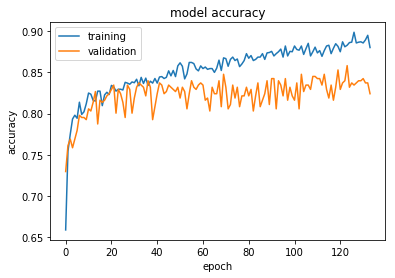

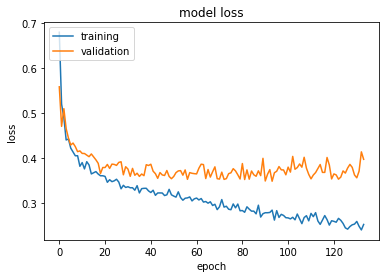

In [88]:
history_pes = LossHistory()
es_pes = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss_pes = model.fit(X_train_ps, y_train_ps, epochs=150, batch_size=32,
                callbacks=[history_pes,es_pes],
                validation_data=(X_test_ps,y_test_ps), verbose=2)
score_pes = model.evaluate(X_test_ps, y_test_ps, batch_size=32)
print('loss and accuracy:: ',score_pes)

plt.plot(hiss_pe.history['acc'])
plt.plot(hiss_pe.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_pe.history['loss'])
plt.plot(hiss_pe.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

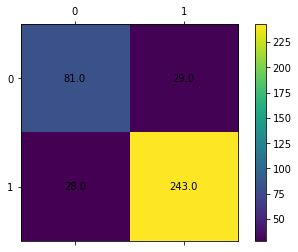

In [89]:
conf_matrix(X_test_ps,y_test_ps,model)

C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 79.34%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 79.28%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 81.22%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 84.25%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 82.87%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 84.25%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.66%
81.70% (+/- 1.97%)


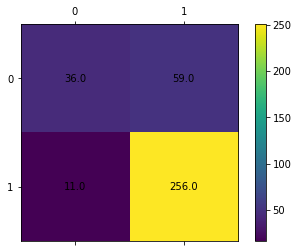

In [90]:
XXX2=summer_pca_s

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score 
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(XXX2, y):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = XXX2[train]
    X_test = XXX2[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, y[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(y[test], y_pred)
    acc = accuracy_score(y[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

Epoch 00067: early stopping
acc: 80.17%


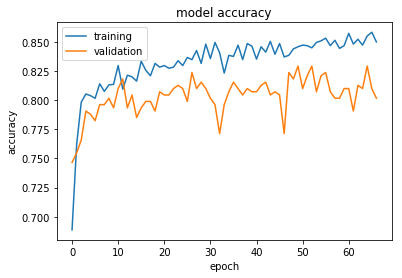

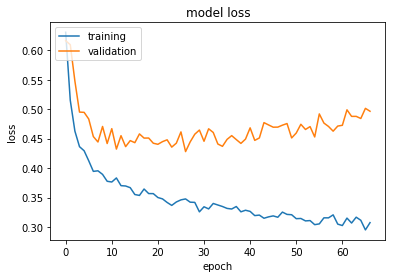

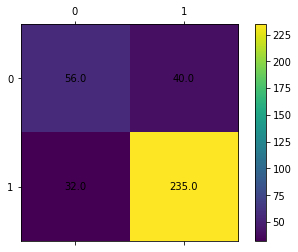

Epoch 00097: early stopping
acc: 82.87%


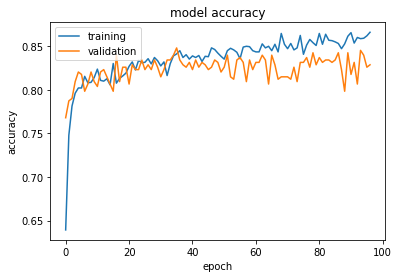

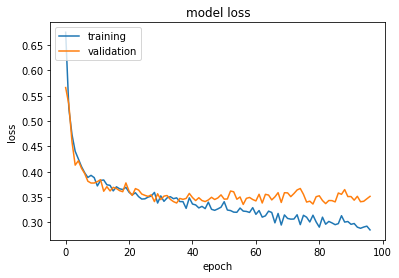

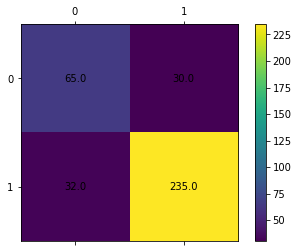

Epoch 00087: early stopping
acc: 82.60%


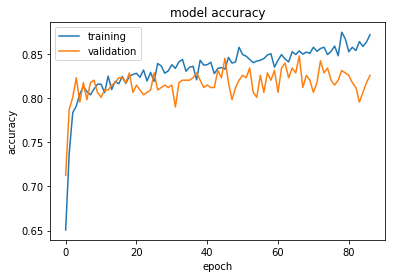

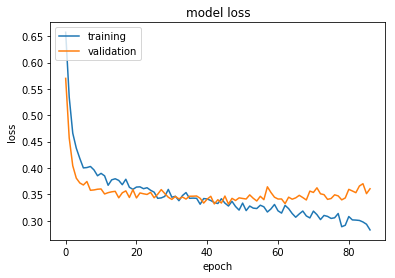

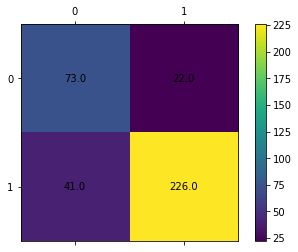

Epoch 00097: early stopping
acc: 83.70%


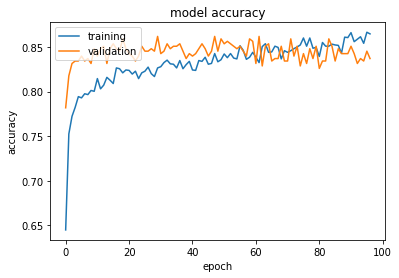

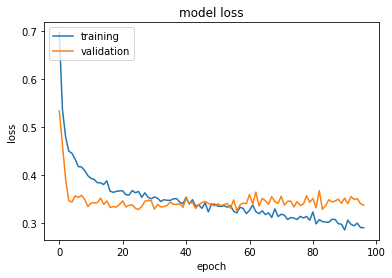

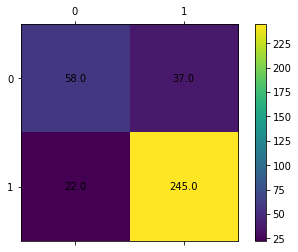

Epoch 00089: early stopping
acc: 81.77%


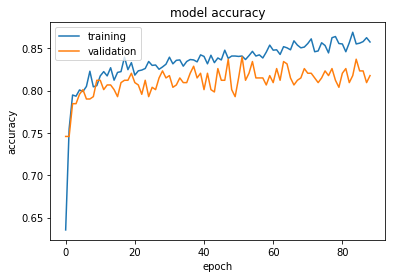

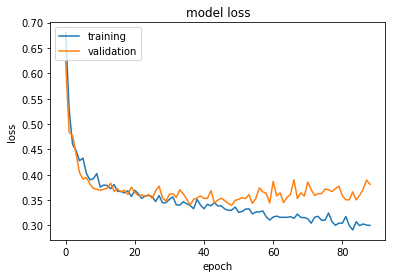

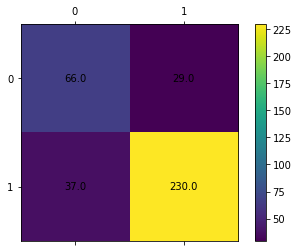

Epoch 00081: early stopping
acc: 83.98%


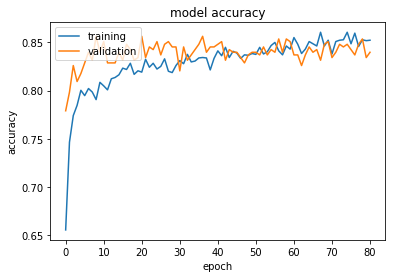

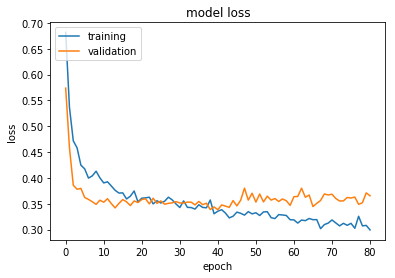

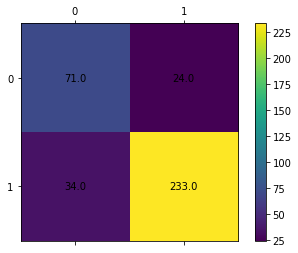

Epoch 00081: early stopping
acc: 82.04%


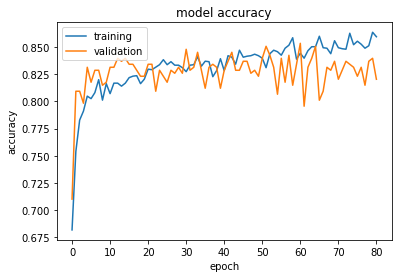

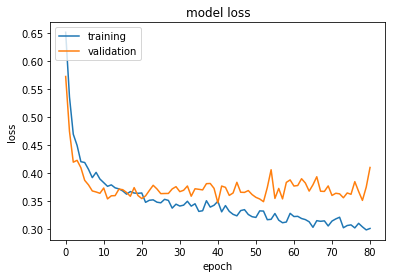

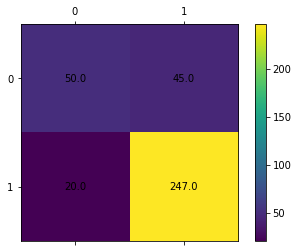

In [92]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold_p = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores_p = []
loss_p = []
for train, test in kfold_s.split(XXX2, y):
    
    model = init_model(14)
    
    X_train_kp =XXX2[train].reshape(XXX2[train].shape[0], XXX2[train].shape[1], 1)
    X_test_kp = XXX2[test].reshape(XXX2[test].shape[0], XXX2[test].shape[1], 1)
    history_kp = LossHistory()
    es_kp = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    hiss_kp = model.fit(X_train_kp, y[train], epochs=150, batch_size=32,
                callbacks=[history_kp,es_kp],
                validation_data=(X_test_kp,y[test]), verbose=0)
    scores_kp = model.evaluate(X_test_kp, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores_kp[1]*100))
    cvscores_p.append(scores_kp[1] * 100)
    loss_p.append(scores_kp[0])
#     print(score)
    plt.plot(hiss_kp.history['acc'])
    plt.plot(hiss_kp.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss_kp.history['loss'])
    plt.plot(hiss_kp.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_kp,y[test],model)

PCA+SA:
------

In [97]:
import shap

# select a set of background examples to take an expectation over
background = X_train_p
X_train_p.shape

(2154, 18, 1)

In [98]:
model = init_model(18)
# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
shap_values = e.shap_values(X_train_p)

In [99]:
shap_values[0]= shap_values[0].reshape(shap_values[0].shape[0],shap_values[0].shape[1])
shap_values[0].shape

X_postprocess = X_train_p.reshape(X_train_p.shape[0],X_train_p.shape[1])
X_postprocess.shape

(2154, 18)

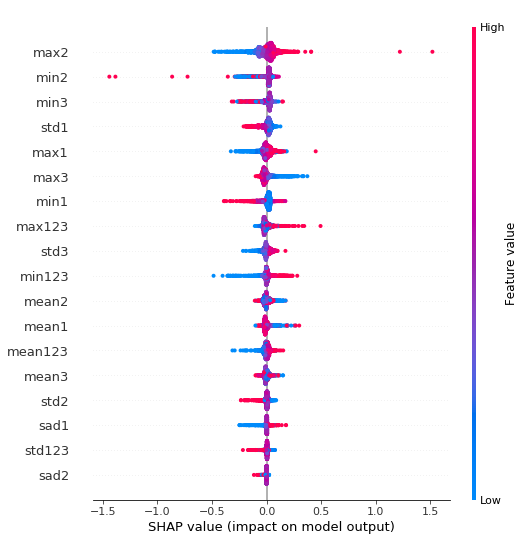

In [100]:
shap.summary_plot(shap_values[0], X_postprocess, feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

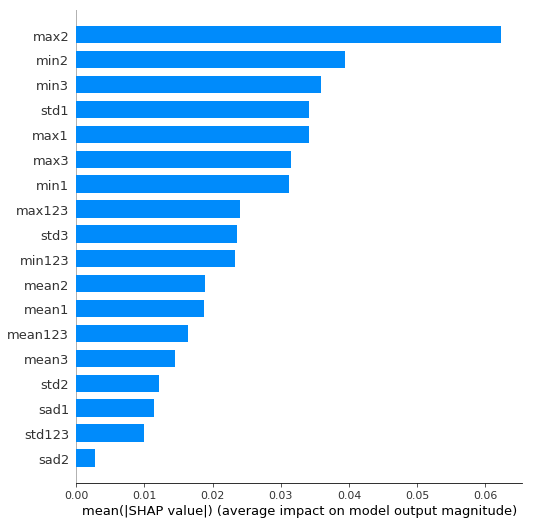

In [101]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar", feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

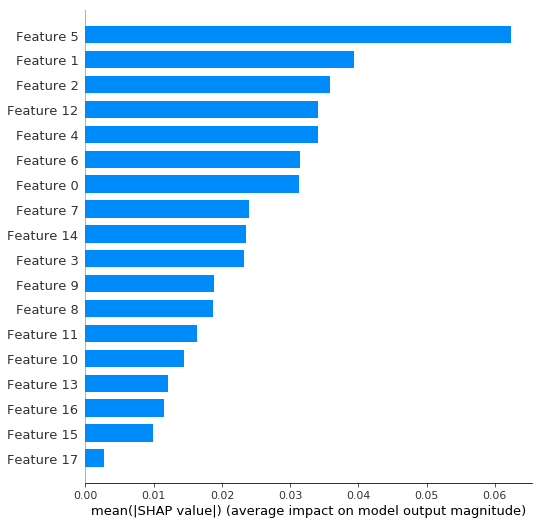

In [102]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar")